In [20]:
import os 
import pandas as pd 
import numpy as np 
import wandb

import matplotlib.pyplot as plt 
%matplotlib inline 

import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from PIL import Image
import math

pd.set_option('display.max_colwidth', None)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Hyperparameters
EMBEDDING_DIM = 104
HIDDEN_DIM = 512
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 4
NUM_EPOCHS = 50
NUM_HEADS = 8
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
CAPTIONS_LENGTH = 25
MAX_PLATEAU_COUNT = 15
NUM_CYCLES = 3
# Some paths and files

IMAGE_PATH = 'data/flickr8k/Images/'
CAPTIONS_FILE = 'data/flickr8k/captions.txt'
EMBEDDING_FILE = 'embedding/glove-wiki-gigaword-100.txt'
CHECKPOINT_PATH = 'data/checkpoints/checkpoint.pth'

cuda


In [22]:
df = pd.read_csv(CAPTIONS_FILE, sep=',')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


100    Two different breeds of brown and white dogs play on the beach .
101                   Two dogs are making a turn on a soft sand beach .
102                         Two dogs playing in the sand at the beach .
103                              Two dogs playing together on a beach .
104                       Two large tan dogs play along a sandy beach .
Name: caption, dtype: object


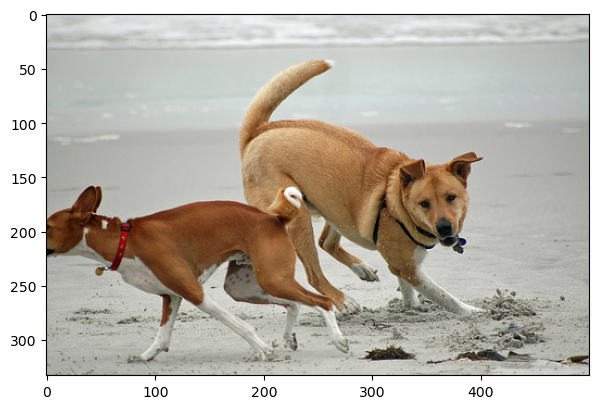

In [23]:
img = Image.open(IMAGE_PATH + df['image'][100])
plt.figure(figsize=(7, 7))
plt.imshow(img)
print(df['caption'][100:105])

In [24]:
vocab, embeddings = [], []
with open(EMBEDDING_FILE, 'rt', encoding='utf-8') as fr:
    full_content = fr.read().strip().split('\n')

for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    i_embeddings.extend([0.0, 0.0, 0.0, 0.0])
    vocab.append(i_word)
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

unk_embedding = np.mean(embs_npa, axis=0).tolist()

dim = embs_npa.shape[1]
sos_embedding = [0.0] * dim
sos_embedding[-3] = 1.0
eos_embedding = [0.0] * dim
eos_embedding[-2] = 1.0
pad_embedding = [0.0] * dim
pad_embedding[-4] = 1.0
# unk_embedding = [0.0] * dim
# unk_embedding[-1] = 1.0

# Update vocab and embeddings
vocab = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"] + vocab
embeddings = [pad_embedding, sos_embedding, eos_embedding, unk_embedding] + embeddings

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

# embs_tensor = torch.from_numpy(embs_npa)


In [25]:
from numpy import nonzero

def tokenize(text):
    return text.lower().strip().split()

def stoi(string):
    if string in vocab_npa:
        return nonzero(vocab_npa == string)[0][0]
    return nonzero(vocab_npa == "<UNK>")[0][0] 

def numericalize(text):
    tokenized_text = tokenize(text)
    return [
        stoi(token)
        for token in tokenized_text
    ]

# def itov(tensor):
#     res = torch.empty(len(tensor), EMBEDDING_DIM)
#     for idx in range(len(tensor)):
#         res[idx, :] = embs_tensor[idx]
#     return res

# def itov_single(idx):
#     return embs_tensor[idx]
        

In [26]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions, image_ids, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.captions_augmented = []
        self.imgs_augmented = []
        self.next_token = []
        for caption, img in zip(captions, image_ids):
            numericalized_caption = [stoi("<SOS>")]
            numericalized_caption += numericalize(caption)
            numericalized_caption.append(stoi("<EOS>"))
            for idx in range(min(len(numericalized_caption), CAPTIONS_LENGTH) - 1):
                self.imgs_augmented.append(img)
                # pre-pad here
                padded_caption = numericalized_caption[:idx+1] + [stoi('<PAD>')] * CAPTIONS_LENGTH
                padded_caption = padded_caption[:CAPTIONS_LENGTH]
                self.captions_augmented.append(padded_caption)
                self.next_token.append(numericalized_caption[idx + 1])
            

    def __len__(self):
        return len(self.captions_augmented)

    def __getitem__(self, idx):
        caption = torch.tensor(self.captions_augmented[idx])

        img_id = self.imgs_augmented[idx]
        img_path = os.path.join(self.root_dir, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # next_token = itov_single(self.next_token[idx])

        # return image, caption, next_token
        return image, caption, self.next_token[idx]
        
        


In [27]:
from sklearn.model_selection import train_test_split

# Load captions
with open(CAPTIONS_FILE, 'r') as f:
    captions_data = f.readlines()[1:]  # Skip header if present

# Process captions and group them by image IDs
from collections import defaultdict

image_captions_dict = defaultdict(list)

for line in captions_data:
    img_id, caption = line.strip().split(',', 1)
    image_captions_dict[img_id].append(caption)

# Get a list of unique image IDs
unique_image_ids = list(image_captions_dict.keys())

# Split image IDs into train, val, test
train_imgs, val_test_imgs = train_test_split(unique_image_ids, test_size=0.15, random_state=42)
val_imgs, test_imgs = train_test_split(val_test_imgs, test_size=0.33, random_state=42)

# Function to get captions and image IDs for each set
def get_captions_and_ids(image_ids_subset):
    subset_captions = []
    subset_image_ids = []
    for img_id in image_ids_subset:
        captions = image_captions_dict[img_id]
        subset_captions.extend(captions)
        subset_image_ids.extend([img_id] * len(captions))
    return subset_captions, subset_image_ids

# Get captions and image IDs for each set
train_captions, train_image_ids = get_captions_and_ids(train_imgs)
val_captions, val_image_ids = get_captions_and_ids(val_imgs)
test_captions, test_image_ids = get_captions_and_ids(test_imgs)

train_size = int(len(train_captions) * 0.01)
val_size = int(len(val_captions) * 0.01)

print(train_size, val_size)

train_captions = train_captions[:train_size]
train_image_ids = train_image_ids[:train_size]


val_captions = val_captions[:val_size]
val_image_ids = val_image_ids[:val_size]


343 40


In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Training dataset
train_dataset = FlickrDataset(
    root_dir=IMAGE_PATH,
    captions=train_captions,
    image_ids=train_image_ids,
    transform=transform
)

# Validation dataset
val_dataset = FlickrDataset(
    root_dir=IMAGE_PATH,
    captions=val_captions,
    image_ids=val_image_ids,
    transform=transform
)

# Test dataset
test_dataset = FlickrDataset(
    root_dir=IMAGE_PATH,
    captions=test_captions,
    image_ids=test_image_ids,
    transform=transform
)


In [29]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        # captions = [item[1] for item in batch]
        # captions = nn.utils.rnn.pad_sequence(
        #     captions, batch_first=True, padding_value=self.pad_idx
        # )

        captions = [item[1].unsqueeze(0) for item in batch]
        captions = torch.cat(captions, dim=0)

        next_tokens = torch.tensor([item[2] for item in batch])
        # print(next_tokens[0])
        # next_tokens = torch.cat([item[2] for item in batch], dim=0)
        # print(next_tokens.size())
        return images, captions, next_tokens


In [30]:
pad_idx = stoi("<PAD>")

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

In [31]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, maxlen=50):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* (np.log(10000) / emb_size))
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        self.pos_embedding = pos_embedding.unsqueeze(-2).to(device)

    def forward(self, x):
        x = x + self.pos_embedding[:x.size(0), :]
        return x

In [ ]:
class ImageCaptioningTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_heads, num_encoder_layers, num_decoder_layers, pad_idx):
        super(ImageCaptioningTransformer, self).__init__()
        self.pad_idx = pad_idx

        # CNN Encoder
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        for param in resnet.parameters():
            param.requires_grad = False
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last two layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cnn_linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size, nhead=num_heads
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        # Embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=True)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(emb_size=embed_size)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, nhead=num_heads
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_decoder_layers
        )

        # Output Layer
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def make_src_mask(self, src):
        # src: [batch_size, src_len]
        src_mask = (src != self.pad_idx).unsqueeze(-2)
        return src_mask

    def forward(self, images, captions):
        # Encode images
        features = self.cnn(images)  # [batch_size, C, H, W]
        features = self.avgpool(features).squeeze(-1).squeeze(-1)  # [batch_size, C]
        features = self.cnn_linear(features)  # [batch_size, embed_size]
        features = self.bn(features)  # [batch_size, embed_size]
        features = features.unsqueeze(1)  # [batch_size, 1, embed_size]
    
        # Transformer Encoder
        encoder_outputs = self.transformer_encoder(features.permute(1, 0, 2))  # [1, batch_size, embed_size]
    
        # Prepare captions
        embeddings = self.embedding(captions)  # [batch_size, seq_len, embed_size]
        embeddings = embeddings.permute(1, 0, 2)  # [seq_len, batch_size, embed_size]
        embeddings = self.positional_encoding(embeddings)
    
        # Create masks
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(CAPTIONS_LENGTH).to(embeddings.device)
        # tgt_mask = torch.triu(torch.ones((CAPTIONS_LENGTH, CAPTIONS_LENGTH), device=captions.device), diagonal=1).bool()

        tgt_key_padding_mask = (captions == self.pad_idx)  # Corrected line
        
        # Transformer Decoder
        outputs = self.transformer_decoder(
            embeddings,
            encoder_outputs,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )  # [seq_len, batch_size, embed_size]

        # Extract the last time step's output
        outputs = outputs[-1, :, :]  # [batch_size, embed_size]
    
        outputs = self.fc_out(outputs)  # [batch_size, vocab_size]

        return outputs # [batch_size, vocab_size]


In [33]:
model = ImageCaptioningTransformer(
    embed_size=EMBEDDING_DIM,
    vocab_size=len(vocab_npa),
    hidden_size=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    pad_idx=pad_idx
).to(device)

# criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


/home/thanh309/miniconda3/envs/thanh309-ml/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
def linear_warmup_decay(step, warmup_steps, total_steps):
    if step < warmup_steps:
        return (step + 1) / (warmup_steps + 1)
    else:
        return max(1e-7, (total_steps - step) / (total_steps - warmup_steps))
    
def warmup_cosine_with_restarts(step, warmup_steps, total_steps, num_cycles=1):
    if step < warmup_steps:
        return (step + 1) / (warmup_steps + 1)
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        cycle_progress = progress * num_cycles % 1
        return max(1e-7, 0.5 * (1 + math.cos(math.pi * cycle_progress)))

total_steps = NUM_EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: linear_warmup_decay(step, warmup_steps, total_steps))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: warmup_cosine_with_restarts(step, warmup_steps, total_steps, num_cycles=NUM_CYCLES)
)

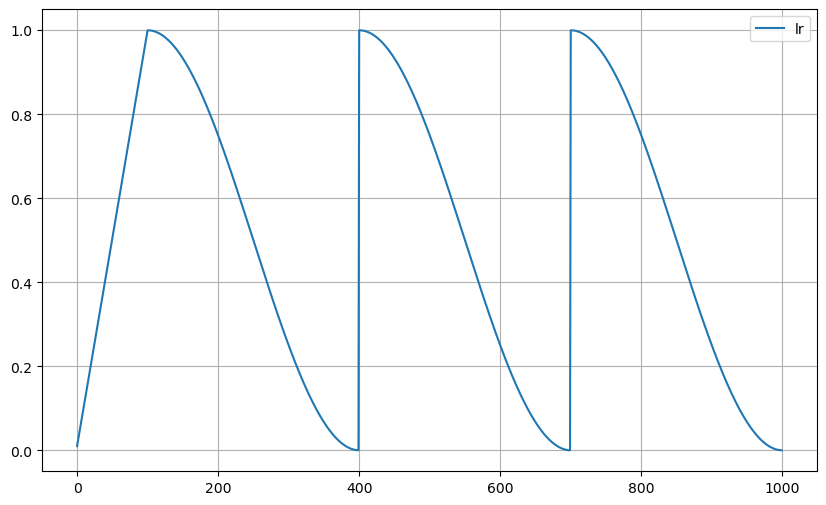

In [35]:
_total_steps = 1000
_warmup_steps = 100
_num_cycles = 3
_steps = range(_total_steps)
_lrs = [warmup_cosine_with_restarts(step, _warmup_steps, _total_steps, _num_cycles) for step in _steps]

plt.figure(figsize=(10, 6))
plt.plot(_steps, _lrs, label='lr')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import time
import torch
import wandb
import datetime

PROJECT = 'DL-Image-captioning'
RESUME = 'allow'
wandb.init(
    project=PROJECT,
    resume=RESUME,
    name=str(datetime.datetime.now()),
    config={
        'embedding_dim': EMBEDDING_DIM,
        'num_encoder_layer': NUM_ENCODER_LAYERS,
        'num_decoder_layer': NUM_DECODER_LAYERS,
        'num_epochs': NUM_EPOCHS,
        'num_head': NUM_HEADS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'max_plateau_count': MAX_PLATEAU_COUNT,
        'num_cycle': NUM_CYCLES,
        'train_size': train_size,
        'val_size': val_size
    }
)
wandb.watch(model)


# Initialize the best validation loss to a high value
best_val_loss = float('inf')
plateau_count = 0

for epoch in range(NUM_EPOCHS):
    curr_lr = lr_scheduler.get_last_lr()[0]
    start_time = time.time()
    
    model.train()  # Set model to training mode
    total_train_loss = 0

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")

    for idx, (images, captions, next_tokens) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        next_tokens = next_tokens.to(device)

        optimizer.zero_grad()
        outputs = model(images, captions)

        loss = criterion(outputs, next_tokens)
        loss.backward()
        optimizer.step()

        lr_scheduler.step()

        total_train_loss += loss.item()

        # Print training loss at each step
        # print(f"Training Step [{idx+1}/{len(train_loader)}], Training Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss for Epoch {epoch+1}: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0

    with torch.no_grad():
        for val_idx, (images, captions, next_tokens) in enumerate(val_loader):
            images = images.to(device)
            captions = captions.to(device)
            next_tokens = next_tokens.to(device)

            outputs = model(images, captions)

            loss = criterion(outputs, next_tokens)
            total_val_loss += loss.item()

            # Print validation loss at each step
            # print(f"Validation Step [{val_idx+1}/{len(val_loader)}], Validation Loss: {loss.item():.4f}")

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Average Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed in {(end_time - start_time)/60:.2f} minutes.")

    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        plateau_count = 0
        best_val_loss = avg_val_loss
        print("Validation loss improved. Not saved")
        # torch.save({
        #     'epoch': epoch + 1,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss': avg_val_loss,
        # }, CHECKPOINT_PATH)
        # print(f"Validation loss improved. Model checkpoint saved at epoch {epoch+1}.")
    else:
        plateau_count += 1
        print("Validation loss did not improve.")

    print('-' * 50)

    wandb.log({
        'epoch': epoch + 1,
        'avg_train_loss': avg_train_loss,
        'avg_val_loss': avg_val_loss,
        'best_val_loss': best_val_loss,
        'starting_lr': curr_lr
    })

    if plateau_count == MAX_PLATEAU_COUNT:
        break

    model.train()  # Set model back to training mode for next epoch

wandb.finish()


Epoch [1/50]
Average Training Loss for Epoch 1: 9.8994
Average Validation Loss for Epoch 1: 9.2340
Epoch [1/50] completed in 0.37 minutes.
Validation loss improved. Not saved
--------------------------------------------------

Epoch [2/50]
Average Training Loss for Epoch 2: 8.8066
Average Validation Loss for Epoch 2: 8.4316
Epoch [2/50] completed in 0.36 minutes.
Validation loss improved. Not saved
--------------------------------------------------

Epoch [3/50]
Average Training Loss for Epoch 3: 7.8726
Average Validation Loss for Epoch 3: 7.4017
Epoch [3/50] completed in 0.37 minutes.
Validation loss improved. Not saved
--------------------------------------------------

Epoch [4/50]
Average Training Loss for Epoch 4: 6.6527
Average Validation Loss for Epoch 4: 6.2610
Epoch [4/50] completed in 0.36 minutes.
Validation loss improved. Not saved
--------------------------------------------------

Epoch [5/50]
Average Training Loss for Epoch 5: 5.5424
Average Validation Loss for Epoch 5:

KeyboardInterrupt: 

In [ ]:
# '''Testing model'''
# import torch


# trained_model = ImageCaptioningTransformer(
#     embed_size=EMBEDDING_DIM,
#     vocab_size=len(vocab_npa),
#     hidden_size=HIDDEN_DIM,
#     num_heads=NUM_HEADS,
#     num_encoder_layers=NUM_ENCODER_LAYERS,
#     num_decoder_layers=NUM_DECODER_LAYERS,
#     pad_idx=pad_idx
# ).to(device)
# state_dict = torch.load('data/checkpoints/checkpoint.pth', weights_only=True)['model_state_dict']
# trained_model.load_state_dict(state_dict)
# trained_model.eval()
# pass

In [ ]:
# img_path = 'data/flickr8k/Images/972381743_5677b420ab.jpg'
# # img_path = 'test.jpg'
# img = transform(Image.open(img_path).convert("RGB"))
# img = torch.unsqueeze(img, 0).to(device)


# max_caption_len = 15
# pad_idx = stoi('<PAD>')
# sos_idx = stoi('<SOS>')
# eos_idx = stoi('<EOS>')
# caption = [[pad_idx for _ in range(max_caption_len)]]
# # caption = [[pad_idx]]
# caption = torch.tensor(caption).to(device)
# caption[0, 0] = sos_idx
# caption_str = '<SOS> '

# next_idx = 1
# with torch.no_grad():
#     while next_idx < max_caption_len:
#         output = trained_model(img, caption)
#         output = torch.argmax(output).item()

#         caption_str += f'{vocab_npa[output]} '
#         caption[0, next_idx] = output
#         # caption = torch.cat((caption, torch.tensor([[output]]).to(device)), dim=1)
#         if output == eos_idx:
#             break
#         next_idx += 1


# plt.imshow(Image.open(img_path).convert("RGB"))
# print(caption_str)